In [39]:
import pandas as pd
import numpy as np
import utils as utils
import statsmodels.api as sm
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Cleaning

In [40]:
# Import brka data

brk_data = pd.read_csv("data/BRK-A.csv", parse_dates=True, index_col=0)
brk_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-01,8675.0,8725.0,6950.0,7455.0,7455.0,1047000
1990-02-01,7455.0,7950.0,7075.0,7225.0,7225.0,751000
1990-03-01,7225.0,7475.0,6675.0,6725.0,6725.0,630000
1990-04-01,6700.0,7025.0,6575.0,6700.0,6700.0,430000
1990-05-01,6700.0,7675.0,6700.0,7150.0,7150.0,427000


In [41]:
# Calculate monthly returns for brka portfolio

brk_data["rets"] = (brk_data["Close"] - brk_data["Open"]) / brk_data["Open"]
brk_data = brk_data.to_period('M')
brk_data.tail()

,Open,High,Low,Close,Adj Close,Volume,rets
Date,,,,,,,
2020-05,278121.0,280899.0,250926.00,278640.0,278640.0,8500,0.001866
2020-06,278167.0,304990.0,262700.00,267300.0,267300.0,13700,-0.039066
2020-07,267600.0,294870.0,266357.00,293631.0,293631.0,7700,0.097276
2020-08,295000.0,323500.0,294510.00,316251.0,316251.0,45000,0.072037
2020-08,317300.0,318000.0,315402.25,316251.0,316251.0,222,-0.003306


In [42]:
# Import fama-french data and convert to %

fff_data = pd.read_csv("data/fama_french.csv", header=0, index_col=0, na_values=-99.99)/100
fff_data.index = pd.to_datetime(fff_data.index, format="%Y%m").to_period('M')
fff_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2020-02,-0.0813,-0.0007,-0.0401,-0.0164,-0.0253,0.0012
2020-03,-0.1339,-0.0845,-0.1412,-0.0133,0.0122,0.0012
2020-04,0.1365,0.0282,-0.0127,0.0259,-0.0109,0.0000
2020-05,0.0558,0.0192,-0.0495,0.0072,-0.0332,0.0001
2020-06,0.0245,0.0189,-0.0203,0.0013,0.0037,0.0001


# CAPM Benchmark

Text(0.5, 1.0, 'CAPM')

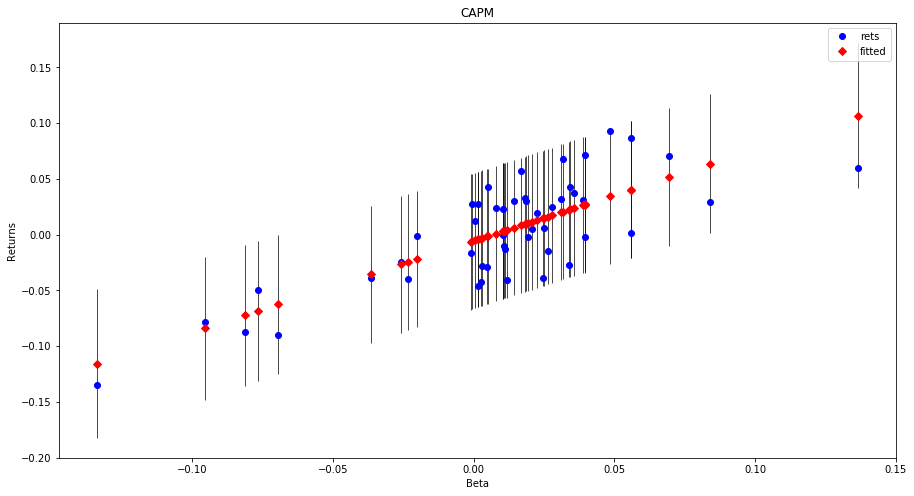

In [43]:
brka_excess = brk_data.loc["2016-06":"2020-06", ['rets']] - fff_data.loc["2016-06":"2020-06", ['RF']].values
mkt_excess = fff_data.loc["2016-06":"2020-06", ['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
capm_lm = sm.OLS(brka_excess, exp_var).fit()

fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.plot_fit(capm_lm, 0 , ax=ax)
ax.set_ylabel("Returns")
ax.set_xlabel("Beta")
ax.set_title("CAPM")

In [44]:
capm_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     74.21
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           3.13e-11
Time:                        17:16:58   Log-Likelihood:                 103.54
No. Observations:                  49   AIC:                            -203.1
Df Residuals:                      47   BIC:                            -199.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8228      0.096      8.614      0.000       0.631       1.015
Constant      -0.0056      0.004     -1.278      0.208      -0.014       0.003
==============================================================================
Omnibus:                        3.885   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                1.776
Skew:                           0.015   Prob(JB):                        0.412
Kurtosis:                       2.068   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CAPM Interpretation
Each dollar in the BRKA portfolio is equivalent to 82 cents in Treasury Bills and 18 cents in the market

𝛼 value of 0.56% relative to market

# Fama-French Benchmark

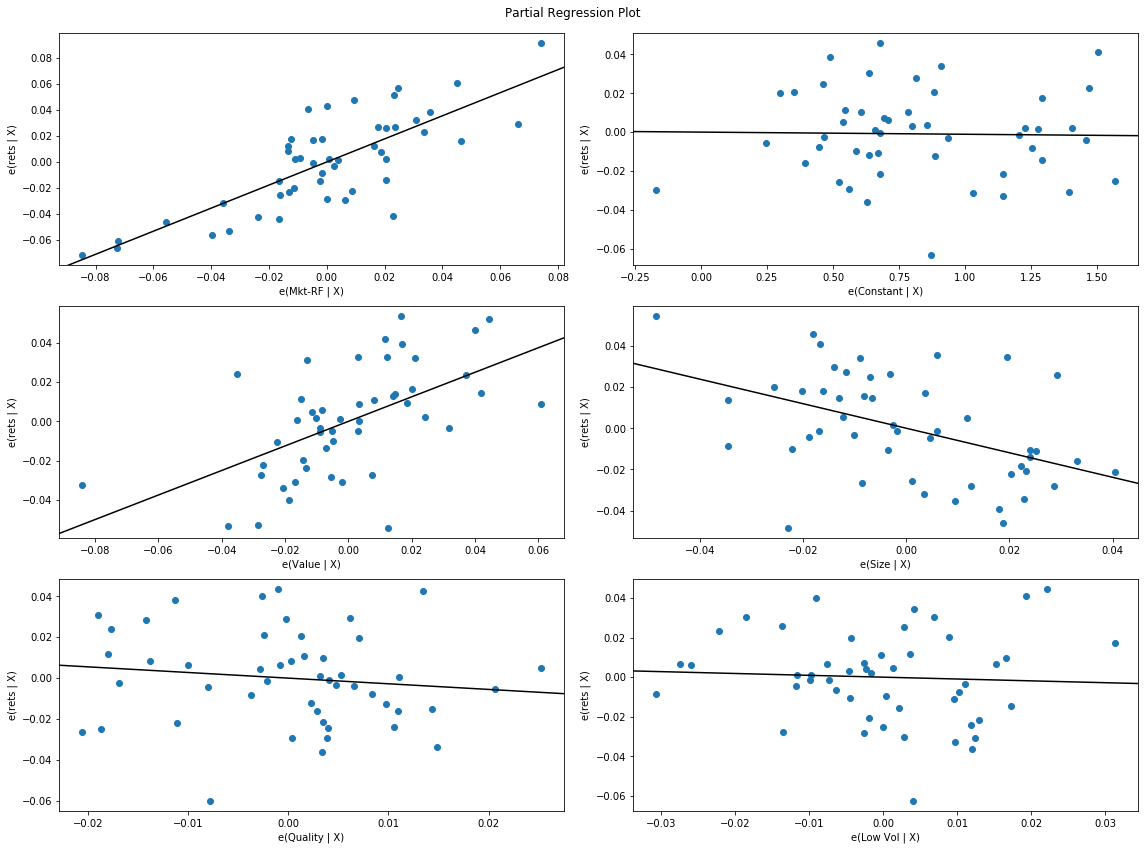

In [45]:
exp_var["Value"] = fff_data.loc["2016-06":"2020-06",['HML']]
exp_var["Size"] = fff_data.loc["2016-06":"2020-06",['SMB']]
exp_var["Quality"] = fff_data.loc["2016-06":"2020-06",['RMW']]
exp_var["Low Vol"] = fff_data.loc["2016-06":"2020-06",['CMA']]
fff_lm = sm.OLS(brka_excess, exp_var).fit()

fig = plt.figure(figsize=(16,12))
sm.graphics.plot_partregress_grid(fff_lm, fig=fig)
plt.show()

In [46]:
fff_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     29.18
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           8.57e-13
Time:                        17:16:59   Log-Likelihood:                 116.59
No. Observations:                  49   AIC:                            -221.2
Df Residuals:                      43   BIC:                            -209.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8870      0.108      8.236      0.000       0.670       1.104
Constant      -0.0011      0.004     -0.294      0.770      -0.009       0.006
Value          0.6249      0.138      4.528      0.000       0.347       0.903
Size          -0.5960      0.173     -3.449      0.001      -0.945      -0.248
Quality       -0.2754      0.324     -0.850      0.400      -0.929       0.378
Low Vol       -0.0930      0.264     -0.353      0.726      -0.625       0.439
==============================================================================
Omnibus:                        0.264   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.876   Jarque-Bera (JB):                0.116
Skew:                          -0.117   Prob(JB):                        0.944
Kurtosis:                       2.957   Cond. No.                         99.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fama-French Interpretation
 - BRKA primarily invests in value stocks
 - BRKA for everydollar:
     - 89 cents in market, 11 cents in T-bills
     - Long 62 cents on value stocks, short 62 cents in growth stocks
     - Short 60 cents in Smallcaps, Long 60 cents in LargeCaps
     - Long 28 cents on profitable companies, short 28 cents on non-profitable companies
     - Short 9 cents on low-vol stocks, long 9 cents on high-vol stocks
 - If we follow the above, we will outperform BRKA by 0.11%